# Generic Reservoir Analysis: Uniform Monthly Release Assumption

## Introduction

This notebook provides a generic analysis framework for assessing the validity of the Uniform Monthly Release Assumption for any reservoir. We compare daily and monthly release models to understand potential discrepancies in spill and penstock flow calculations.

To use this notebook, you need to provide:
1. The reservoir name (e.g., 'Folsom')
2. The penstock capacity in CFS

Currently the notebook uses the Water Year Types for the Sacremento. Change this file if your reservoir is not in the Sacramento river basin (https://cdec.water.ca.gov/reportapp/javareports?name=WSIHIST)

Make sure you have the following data files in the same directory as this notebook:
1. '[ReservoirName]_Outflow.xlsx' - Daily release data for your reservoir
2. 'Water_Year_Types.csv' - Historic water year types

Note: You may need to adjust the code if your data differs significantly.


In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


### User Inputs here

In [2]:
# User inputs
reservoir_name = "Oroville"  # Change this to your reservoir name. The options are 'Shasta', 'Folsom', 'Oroville'
penstock_capacity = 16950  # Change this to your reservoir's penstock capacity in CFS
#Shasta penstock_capacity = 17600
#Oroville penstock_capacity = 16950
#Folsom penstock_capacity = 6900


# Global parameters
cfs_to_afd = 1.983  # Unit conversion CFS to AFD

In [3]:
# Load daily release data 
outflow_file = f'{reservoir_name}_Outflow.xlsx'
reservoir_outflow = pd.read_excel(outflow_file)
reservoir_outflow = reservoir_outflow[['OBS DATE', 'VALUE']]
reservoir_outflow['VALUE'] = pd.to_numeric(reservoir_outflow['VALUE'].str.replace(',', ''))
reservoir_outflow['OBS DATE'] = pd.to_datetime(reservoir_outflow['OBS DATE'])
reservoir_outflow.set_index('OBS DATE', inplace=True)

C:\Users\amonkar\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# Segment data to WY 1997 - WY 2023
reservoir_outflow = reservoir_outflow['1996-10-01':'2023-09-30']

In [5]:
# Load historic water year types
wy_types = pd.read_csv("Water_Year_Types.csv", index_col=0)
wy_types.index = pd.to_datetime(wy_types.index)
wy_types = wy_types[wy_types.index > '1996-09-30']
wy_types.index = wy_types.index + pd.offsets.MonthEnd(0)  # Align index to the end of the month

## Analysis

### Daily Time Step Analysis

In [6]:
# Calculate daily spill
daily_spill = (reservoir_outflow['VALUE'] - penstock_capacity).clip(lower=0)
daily_spill = daily_spill * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day
daily_spill = daily_spill.resample('M').sum()  # Aggregate to monthly

# Calculate daily penstock flow
daily_penstock = reservoir_outflow['VALUE'].clip(upper=penstock_capacity)
daily_penstock = daily_penstock * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day
daily_penstock = daily_penstock.resample('M').sum()  # Aggregate to monthly

### Monthly Time Step Analysis

In [7]:
# Aggregate total releases to monthly time-step
monthly_flow = pd.DataFrame({
    'Flow': reservoir_outflow['VALUE'].resample('M').sum(),  # Total Monthly Releases
    'DPM': reservoir_outflow['VALUE'].resample('M').count()  # Days per month (Accounts for missing days as well)
})

# Calculate monthly spill
monthly_spill = (monthly_flow['Flow'] - monthly_flow['DPM'] * penstock_capacity).clip(lower=0)
monthly_spill = monthly_spill * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day

# Calculate monthly penstock flow
monthly_penstock = monthly_flow['Flow'].clip(upper=monthly_flow['DPM'] * penstock_capacity)
monthly_penstock = monthly_penstock * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day

## Metric Calculations

### Metric I: Underestimation of Spill

In [8]:
spill_underestimation = 100 * (sum(daily_spill) - sum(monthly_spill)) / sum(monthly_spill)
print(f'Underestimation of spill for {reservoir_name}: {round(spill_underestimation, 2)}%')

Underestimation of spill for Oroville: 66.39%


In [9]:
penstock_overestimation = 100 * (sum(monthly_penstock) - sum(daily_penstock)) / sum(daily_penstock)
print(f'Over-estimation of penstock flow for {reservoir_name}: {round(penstock_overestimation, 2)}%')

Over-estimation of penstock flow for Oroville: 3.37%


### Monthly Distribution of Penstock Flow Overestimation

In [10]:
penstock_overestimate = pd.DataFrame({
    'Daily': daily_penstock,
    'Monthly': monthly_penstock,
    'WYT': wy_types['SAC_Index']
})
penstock_overestimate['Month'] = penstock_overestimate.index.month

### Penstock overestimates in Jan-Apr

In [11]:
filtered_penstock_overestimate = penstock_overestimate[penstock_overestimate['Month'].isin([1, 2, 3, 4])]
jan_apr_overestimate = 100 * (filtered_penstock_overestimate['Monthly'].sum() - filtered_penstock_overestimate['Daily'].sum()) / filtered_penstock_overestimate['Daily'].sum()
print(f'Over-estimation of penstock flow for {reservoir_name} during Jan-Apr: {round(jan_apr_overestimate, 2)}%')

Over-estimation of penstock flow for Oroville during Jan-Apr: 8.33%


In [12]:
# Function to create the monthly penstock flow overestimation table
def create_penstock_overestimate_table(penstock_overestimate):
    # Ensure the Month column is correctly formatted
    penstock_overestimate['Month'] = pd.to_datetime(penstock_overestimate.index).month
    
    # Function to calculate overestimate value
    def calculate_penstock_overestimate(group):
        daily_sum = group['Daily'].sum()
        monthly_sum = group['Monthly'].sum()
        return round(100 * (monthly_sum - daily_sum) / daily_sum, 2)
    
    # Calculate for all WYTs and Months
    months_by_wyt = penstock_overestimate.groupby(['WYT', 'Month']).apply(calculate_penstock_overestimate).reset_index(name='Calculation')
    
    # Create the pivot table
    pivot_table = months_by_wyt.pivot(index='WYT', columns='Month', values='Calculation')
    
    # Rename columns to month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    pivot_table.columns = month_names
    
    # Calculate 'All Months' column
    all_months = penstock_overestimate.groupby('WYT').apply(calculate_penstock_overestimate)
    pivot_table['All Months'] = all_months
    
    # Calculate 'All Types' row
    all_types = penstock_overestimate.groupby('Month').apply(calculate_penstock_overestimate)
    all_types_row = pd.DataFrame(all_types).T
    all_types_row.index = ['All Types']
    all_types_row.columns = month_names
    all_types_row['All Months'] = calculate_penstock_overestimate(penstock_overestimate)
    
    # Combine all rows
    final_table = pd.concat([pivot_table, all_types_row])
    
    # Reorder columns to match the desired output
    column_order = ['All Months'] + month_names
    final_table = final_table[column_order]
    
    # Define the desired row order
    row_order = ['All Types', 'W', 'AN', 'BN', 'D', 'C']
    final_table = final_table.reindex(row_order)
    
    # Replace NaN with '-'
    final_table = final_table.replace(np.nan, '-')
    
    # Round non-dash values to integers
    final_table = final_table.applymap(lambda x: int(round(x)) if x != '-' else x)

    return final_table

In [13]:
# Create and display the table
penstock_overestimate_table = create_penstock_overestimate_table(penstock_overestimate)
print(f"Penstock Flow Overestimation Table for {reservoir_name} (values in percentage)")
display(penstock_overestimate_table)

Penstock Flow Overestimation Table for Oroville (values in percentage)


,All Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
All Types,3,7,9,14,3,2,0,0,0,0,2,0,11
W,7,11,12,20,5,5,0,0,0,0,4,0,24
AN,0,0,0,0,0,0,0,0,0,0,0,0,0
BN,0,0,1,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visual Analysis

### Spill Analysis Scatterplot

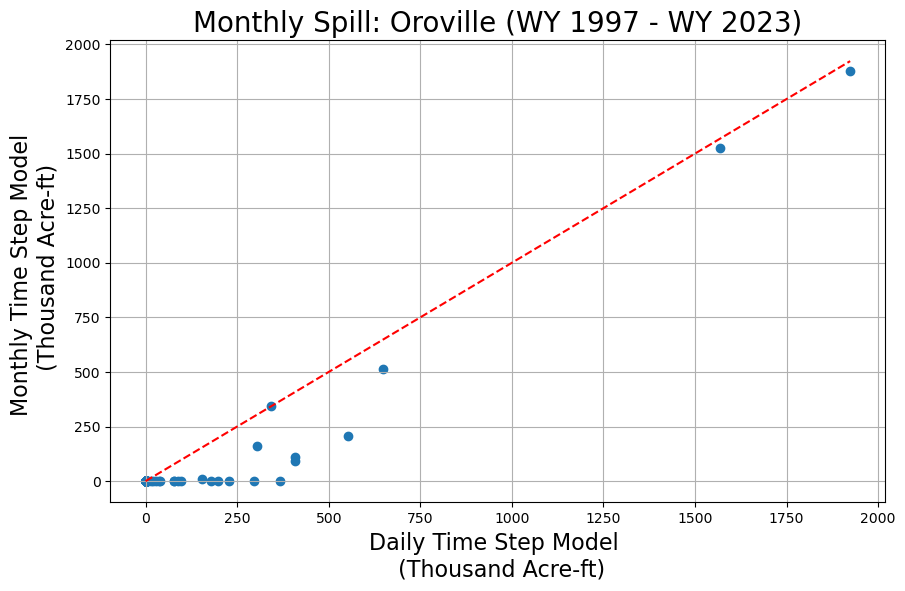

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(daily_spill, monthly_spill)
max_val = max(monthly_spill.max(), daily_spill.max())
min_val = min(monthly_spill.min(), daily_spill.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title(f'Monthly Spill: {reservoir_name} (WY 1997 - WY 2023)', fontsize=20)
plt.xlabel('Daily Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.ylabel('Monthly Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.grid(True)
plt.show()

### Penstock Flow Scatterplot

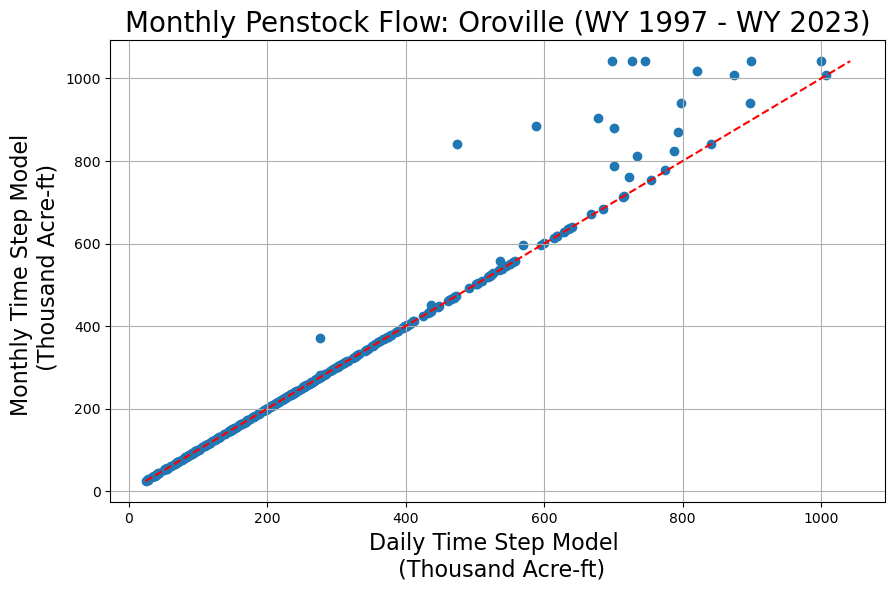

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(daily_penstock, monthly_penstock)
max_val = max(monthly_penstock.max(), daily_penstock.max())
min_val = min(monthly_penstock.min(), daily_penstock.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title(f'Monthly Penstock Flow: {reservoir_name} (WY 1997 - WY 2023)', fontsize=20)
plt.xlabel('Daily Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.ylabel('Monthly Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.grid(True)
plt.show()

### Monthly Counts of Spill Underestimation

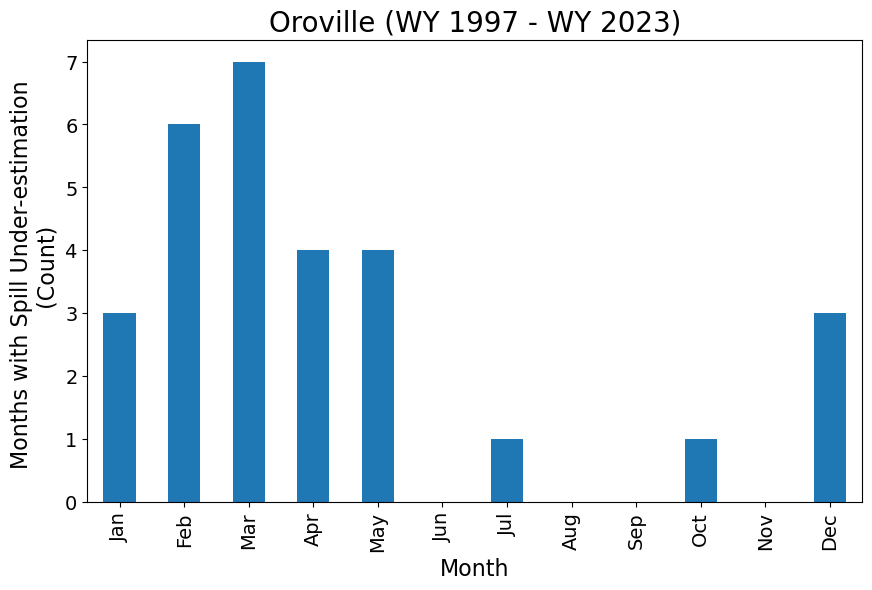

In [16]:
spill_difference = daily_spill - monthly_spill
non_zero_spill = spill_difference[spill_difference != 0]
non_zero_spill = non_zero_spill.reset_index()
non_zero_spill['Month'] = non_zero_spill['OBS DATE'].dt.strftime('%b')  # Extract month as a string
monthly_non_zero_count = non_zero_spill.groupby('Month').count()
monthly_non_zero_count = monthly_non_zero_count.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

monthly_non_zero_count['OBS DATE'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month', fontsize=16)
plt.ylabel('Months with Spill Under-estimation \n (Count)', fontsize=16)
plt.title(f'{reservoir_name} (WY 1997 - WY 2023)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Example Year Visual Analysis (e.g., Wet Water Year)

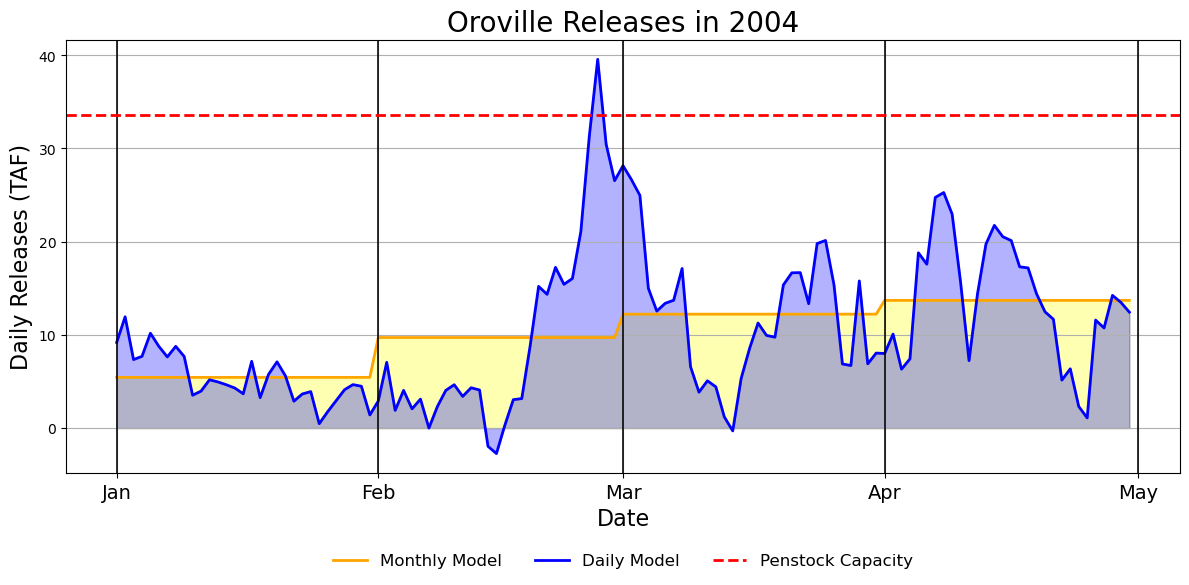

In [17]:
# Choose a specific year for analysis (e.g., a wet water year)
analysis_year = 2004  # Change this to the desired year

# Subset to needed timeframe (January to April of the chosen year)
reservoir_example = reservoir_outflow * cfs_to_afd / 1000  # Convert to TAF
reservoir_example = reservoir_example[f'{analysis_year}-01-01':f'{analysis_year}-04-30']

# Compute the Uniform Monthly Release Assumption Values
monthly_avg = reservoir_example.resample('MS')['VALUE'].mean()
monthly_avg_daily = monthly_avg.reindex(reservoir_example.index, method='ffill')
reservoir_example['Monthly_Avg'] = monthly_avg_daily

plt.figure(figsize=(12, 6))
plt.fill_between(reservoir_example.index, reservoir_example['Monthly_Avg'], 0, color='yellow', alpha=0.3)
plt.plot(reservoir_example.index, reservoir_example['Monthly_Avg'], linewidth=2, color='orange', label='Monthly Model')
plt.fill_between(reservoir_example.index, reservoir_example['VALUE'], 0, color='blue', alpha=0.3)
plt.plot(reservoir_example.index, reservoir_example['VALUE'], linewidth=2, color='blue', label='Daily Model')
plt.title(f'{reservoir_name} Releases in {analysis_year}', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily Releases (TAF)', fontsize=16)
for month in pd.date_range(start=f'{analysis_year}-01-01', end=f'{analysis_year}-05-01', freq='MS'):
    plt.axvline(x=month, color='black', linewidth=1.15)
plt.axhline(y=penstock_capacity * cfs_to_afd / 1000, color='red', linestyle='--', linewidth=2, label='Penstock Capacity')
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=14)
plt.tight_layout()
plt.show()